## Overview

In numerous cities across the United States, there are communal bike sharing stations that allow individuals to rent bicycles either by the hour or by the day. Washington, D.C. is one such city that operates such a system. The District collects comprehensive data regarding the hourly and daily rental counts of bicycles. The dataset comprises 17,380 rows, with each row representing the rental count for a single hour on a specific day.


**Objective**: The main goal of this project is to predict the total number of bicycles that people will rent during a particular hour.




In [265]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

import warnings 

warnings.filterwarnings('ignore')

bike_rentals = pd.read_csv('../data/raw/bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


##  EDA - Insights & Actionables 


In our exploratory data analysis (EDA), we conducted a comprehensive assessment of the dataset. We checked for null values, incorrect data types, and outliers.

- **Null Values**: Fortunately, no missing values were found in the dataset, ensuring data completeness.
- **Data Types**: All variables had appropriate data types, with no data type issues detected.

We also performed a correlation analysis to assess variable relationships, finding no significant concerns related to multicollinearity.

All continuous numerical variables are already on a similar scale, and categorical variables have been converted to numerical format, eliminating the need for further standardization

However, we identified outliers in the target variable, which can distort model performance evaluation. To ensure accurate error metric reporting, we made the decision to remove rows containing outlier values in the target variable.






In [266]:
import pandas as pd

def remove_outliers(df, column_name):

    # Calculate the IQR for the specified column
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to keep only the rows within the bounds
    filtered_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    return filtered_df


bike_rentals.dteday = pd.to_datetime(bike_rentals.dteday)
bike_rentals = remove_outliers(bike_rentals, 'cnt')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Defining Predictors & Target

**Predictor Variables:** All columns except `['casual', 'registered', 'cnt', 'dteday', 'yr']`.

**Target Variable:** `cnt`.

**Explanation:** We exclude 'casual' and 'registered' as they contribute to 'cnt,' making it unsuitable for prediction. Removing 'yr' and 'dteday' to create a time-independent dataset, focusing solely on daily conditions, avoiding predictive issues based on the year in which the day occurred. This ensures that past outcomes are not predicted using future data.



In [289]:
predictors  = bike_rentals.drop(['casual', 'registered', 'cnt', 'dteday', 'yr'], axis = 1)
predictors.info()


<class 'pandas.core.frame.DataFrame'>
Index: 16874 entries, 0 to 17378
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     16874 non-null  int64  
 1   season      16874 non-null  int64  
 2   mnth        16874 non-null  int64  
 3   hr          16874 non-null  int64  
 4   holiday     16874 non-null  int64  
 5   weekday     16874 non-null  int64  
 6   workingday  16874 non-null  int64  
 7   weathersit  16874 non-null  int64  
 8   temp        16874 non-null  float64
 9   atemp       16874 non-null  float64
 10  hum         16874 non-null  float64
 11  windspeed   16874 non-null  float64
dtypes: float64(4), int64(8)
memory usage: 1.7 MB


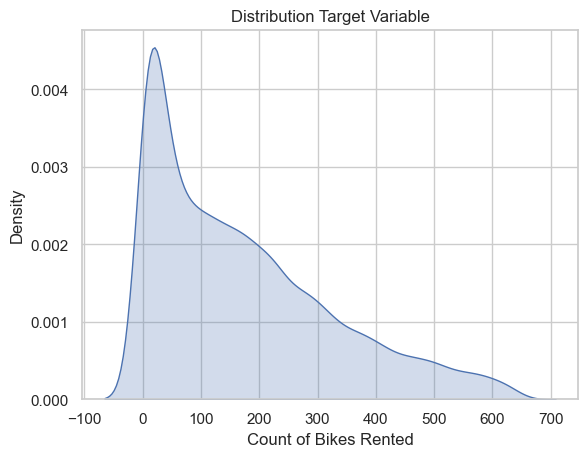

In [287]:
target = bike_rentals.cnt

sns.set(style="whitegrid") 
sns.kdeplot(target, shade=True)  # Create the KDE plot with shading

# Add labels and a title
plt.xlabel("Count of Bikes Rented")  # Replace "X-axis Label" with your actual label
plt.ylabel("Density")  # Replace "Y-axis Label" with your actual label
plt.title("Distribution Target Variable")  # Replace "KDE Plot" with your desired title

# Show the plot
plt.show()

## Model Building 

### Conducting Data Split 

We perform a train-test split with a 20% test set size.

In [268]:
# Train Test Split

from  sklearn.model_selection import train_test_split 

X_train, X_test, Y_train, Y_test =  train_test_split( predictors, target, test_size=0.2, random_state=42)



### Model Selection

#### Use of Cross-Validation

We employed cross-validation as a crucial step in model evaluation. mitigating the risk of overfitting or underfitting, and providing an estimate of how well the model will perform on unseen data.

#### Choice of Folds

For our cross-validation, we selected a 3-fold approach. The choice of the number of folds depends on the dataset's size and complexity. While common choices include 5 or 10 folds, 3-fold cross-validation is appropriate for our dataset, given its characteristics and to ensure we have a sufficient amount of data in each fold for meaningful evaluation.

#### Choice of Candidate Models

We considered three candidate regression models for our analysis:

1. **Linear Regression:** Linear regression is a straightforward linear model, suitable for capturing simple relationships between predictor variables and the target variable.

2. **Decision Tree Regressor:** Decision trees are more complex models capable of capturing non-linear relationships within the data. They can be useful when the underlying patterns are not linear.

3. **Random Forest Regressor:** Random forests are ensemble models built upon decision trees. They are known for their robustness and ability to handle both linear and non-linear relationships. Random forests often provide improved predictive performance.

These candidate models were chosen to offer a diverse set of approaches, allowing us to compare their performance and select the most appropriate one for our prediction task.


In [269]:
#### Using CV to compare different models

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import  LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor



lin_rg = LinearRegression()
dt_rg = DecisionTreeRegressor(random_state = 42)
rf_rg = RandomForestRegressor(random_state = 42)

# Performing cross_val on each model 

n_folds = 3

lin_rg_scores = - cross_val_score(lin_rg, X_train, Y_train, cv = n_folds, scoring = 'neg_root_mean_squared_error')
dt_rg_scores  = -cross_val_score(dt_rg, X_train, Y_train, cv = n_folds, scoring = 'neg_root_mean_squared_error') 
rf_rg_scores = - cross_val_score(rf_rg, X_train, Y_train, cv = n_folds, scoring = 'neg_root_mean_squared_error')





linear_regression_mean_score = np.mean(lin_rg_scores)
decision_tree_mean_score = np.mean(dt_rg_scores)
random_forest_mean_score = np.mean(rf_rg_scores)


print("Average MSE: ")
print( "Linear Regression :" ,linear_regression_mean_score)
print("Decision Tree :", decision_tree_mean_score)
print( "Random Forest :", random_forest_mean_score)
          
      


Average MSE: 
Linear Regression : 121.32163360820334
Decision Tree : 57.94333029892286
Random Forest : 40.96700447247972


**Selected Model**: The **Random Forest model**, with the lowest MSE, has been selected as the algorithm of choice for this problem.

### Hyperparameter Tuning

To enhance the performance of tree-based algorithms, we will be conducting hyperparameter tuning. It is widely recognized that the efficacy of these algorithms can undergo significant changes based on the configuration of hyperparameters.


In [270]:
""" WARNING: Cell has a run-time of 10 mins."""

from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': np.arange(750, 1000, 100),           # Number of trees in the forest
    'max_depth': np.arange(20, 100, 30),             # Maximum depth of the tree
    'min_samples_split': np.arange(0, 5),           # Minimum number of samples required to split an internal node
    'min_samples_leaf': np.arange(0, 5),            # Minimum number of samples required to be at a leaf node
    'random_state': [0, 42, 749]
}

random_search = RandomizedSearchCV( rf_rg, param_distributions=param_grid, scoring = 'neg_root_mean_squared_error', n_iter=100, cv=3, n_jobs=-1, random_state=42, verbose=1)

random_search.fit(X_train, Y_train)



Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': array([20, 50, 80]),
                                        'min_samples_leaf': array([0, 1, 2, 3, 4]),
                                        'min_samples_split': array([0, 1, 2, 3, 4]),
                                        'n_estimators': array([750, 850, 950]),
                                        'random_state': [0, 42, 749]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [271]:
print("Best Hyperparameters: ", random_search.best_params_)
print("Best Score:  ",- random_search.best_score_)

Best Hyperparameters:  {'random_state': 0, 'n_estimators': 850, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 50}
Best Score:   40.607832184224


### Model Fittting

We now fit the final model based on the results of hyperparameter tuning. 

In [272]:
model = RandomForestRegressor(**random_search.best_params_)
model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=50, n_estimators=850, random_state=0)

## Model Evaluation and Diagnostics

In this phase, we will assess the model's performance using data it has not encountered before.
Our goal is to analyze its performance through various error metrics and draw insights to understand how well the model is performing.


In [282]:
# Setting Actual & Predicted Values 

actuals = Y_test
predicted = model.predict(X_test)


def calculate_error_metrics(actuals, predicted):
    
    from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score, explained_variance_score

    abs_errors = np.abs(np.array(actuals) - np.array(predicted))
    
    metrics = {
        "Error Metric": ["Mean Absolute Error (MAE)", "Median Absolute Error","Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)",
                         "R-squared (R²)", "Mean Absolute Percentage Error (MAPE)"],
        "Value": [
            mean_absolute_error(actuals, predicted),
            median_absolute_error(actuals, predicted),
            mean_squared_error(actuals, predicted),
            np.sqrt(mean_squared_error(actuals, predicted)),  # RMSE
            r2_score(actuals, predicted),
            np.mean(abs_errors / np.array(actuals)) * 100  # MAPE
        ]
    }
    
    error_metrics_df = pd.DataFrame(metrics)
    return error_metrics_df


metrics_df = calculate_error_metrics(actuals, predicted)
metrics_df

,Error Metric,Value
0,Mean Absolute Error (MAE),23.125230
1,Median Absolute Error,13.288235
2,Mean Squared Error (MSE),1317.902615
3,Root Mean Squared Error (RMSE),36.302928
4,R-squared (R²),0.943431
5,Mean Absolute Percentage Error (MAPE),29.269926


### Model Performance 


#### Comments on Target Value

Before we begin to evaluate and interpret the model's performance, it's important to note that the target variable exhibits a significant right-skewed distribution. You can visualize this skewness in the distribution of the test set by referring to this [plot](../reports/figures/distribution_plot.jpeg).

Now, let's proceed to explore the metrics and provide an explanation of our model's performance.


#### Analysing Model Evaluation Metrics 

**Mean Absolute Error (MAE):**
- **Interpretation:** MAE is **23.13**, indicating that, on average, predictions deviate by about 23.13 bikes from actual counts.

**Median Absolute Error:**
- **Interpretation:** Median AE is **13.29**, significantly lower than MAE, offering a more robust measure of central prediction error.

**R-squared (R²):**
- **Interpretation:** R² is **0.9434**, suggesting that the model explains about 94.34% of the variance. However, this interpretation should be approached cautiously due to two factors:
   1. **Data Skewness:** The skewed data distribution might lead to a high R² partly because the model fits the majority of data points clustered on one side of the distribution.
   2. **Presence of Outliers:** Outliers, especially extreme values, can disproportionately impact R². The model may perform well for the central data but poorly for extreme values.

**Mean Absolute Percentage Error (MAPE):**

- **Interpretation:** MAPE is **29.27%**, indicating that predictions deviate by approximately 29.27% from actual bike rental counts. Affected by skewed data and outliers.


#### Summary of Model Performance

Upon analyzing the evaluation metrics, we draw the following conclusions:

- The model demonstrates strong performance when dealing with data concentrated on one side of the distribution, indicating its proficiency in predicting values within the range of 0-250 bikes, where about 75%  of the data points are clustered.

- However, its performance deteriorates when faced with values greater than 250. 

Final Summary : The model is dependable when forecasting values within the **0-250** range, which encompasses approximately **75%** of the population. However, extra caution is warranted when the model encounters values exceeding 250.

###